In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('2330-training.csv',  thousands=",")

import warnings

### 去除煩人的 warrning
warnings.filterwarnings('ignore')

In [8]:
df.info()
df.duplicated()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    217 non-null    object 
 1   y       217 non-null    float64
 2   x1      217 non-null    float64
 3   x2      217 non-null    float64
 4   x3      217 non-null    float64
 5   x4      217 non-null    float64
 6   x5      217 non-null    float64
dtypes: float64(6), object(1)
memory usage: 12.0+ KB


0      False
1      False
2      False
3      False
4      False
       ...  
212    False
213    False
214    False
215    False
216    False
Length: 217, dtype: bool

In [9]:
for col in df.columns.drop('Date'):
    df[col] = df[col].astype(int)  # 轉為整數
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    217 non-null    object
 1   y       217 non-null    int32 
 2   x1      217 non-null    int32 
 3   x2      217 non-null    int32 
 4   x3      217 non-null    int32 
 5   x4      217 non-null    int32 
 6   x5      217 non-null    int32 
dtypes: int32(6), object(1)
memory usage: 6.9+ KB


In [10]:
df.head()

,Date,y,x1,x2,x3,x4,x5
0,11/15/2023,581,572,571,557,557,556
1,11/16/2023,583,581,572,571,557,557
2,11/17/2023,580,583,581,572,571,557
3,11/20/2023,577,580,583,581,572,571
4,11/21/2023,585,577,580,583,581,572


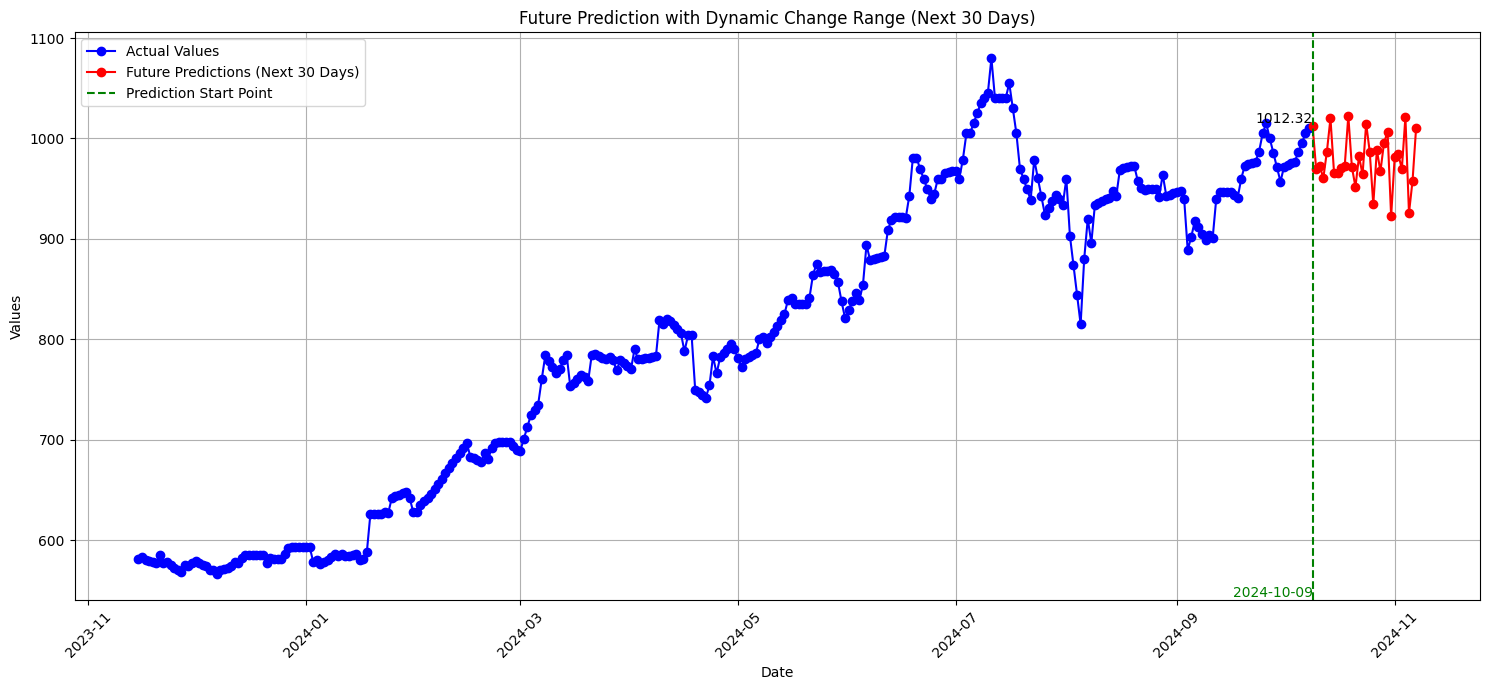

Predicted Value for 2024-10-09: 1012.32
Prediction Range: [862.82, 1161.82]

Predicted Value for 2024-10-10: 969.15
Prediction Range: [819.65, 1118.65]

Predicted Value for 2024-10-11: 972.79
Prediction Range: [823.29, 1122.29]

Predicted Value for 2024-10-12: 960.50
Prediction Range: [811.00, 1110.00]

Predicted Value for 2024-10-13: 986.94
Prediction Range: [837.44, 1136.44]

Predicted Value for 2024-10-14: 1019.98
Prediction Range: [870.48, 1169.48]

Predicted Value for 2024-10-15: 966.05
Prediction Range: [816.55, 1115.55]

Predicted Value for 2024-10-16: 966.08
Prediction Range: [816.58, 1115.58]

Predicted Value for 2024-10-17: 970.27
Prediction Range: [820.77, 1119.77]

Predicted Value for 2024-10-18: 972.84
Prediction Range: [823.34, 1122.34]

Predicted Value for 2024-10-19: 1022.53
Prediction Range: [873.03, 1172.03]

Predicted Value for 2024-10-20: 971.74
Prediction Range: [822.24, 1121.24]

Predicted Value for 2024-10-21: 951.74
Prediction Range: [802.24, 1101.24]

Predicted

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 假設已經有一個 DataFrame `df`，包含 'Date', 'x1', 'x2', 'x3', 'x4', 'x5', 'y'
# 如果尚未載入數據，請使用以下程式碼載入數據：
# df = pd.read_csv('你的數據文件.csv')

# 將 Date 轉換為 datetime 格式
df['Date'] = pd.to_datetime(df['Date'])

# 定義自變量（X）和目標變量（y）
X = df[['x1', 'x2', 'x3', 'x4', 'x5']]
y = df['y']

# 建立線性回歸模型
model = LinearRegression()

# 訓練模型
model.fit(X, y)

# 初始化列表來保存未來預測值和日期
future_predictions = []
future_dates = []

# 使用最後一組數據進行未來30天的預測
last_x_values = X.iloc[-1].values.reshape(1, -1)

# 計算歷史數據的標準差作為變動範圍的依據
std_dev = y.std()

# 定義預測的天數
prediction_days = 30

for i in range(prediction_days):
    # 進行預測
    y_pred = model.predict(last_x_values)[0]
    future_predictions.append(y_pred)

    # 計算下次的 x 值
    # 假設 x1 到 x4 是時間序列的滯後值，將前一組值向左移動，並將 x5 設為當前預測值
    new_x1 = last_x_values[0, 1]  # x2 變為新的 x1
    new_x2 = last_x_values[0, 2]  # x3 變為新的 x2
    new_x3 = last_x_values[0, 3]  # x4 變為新的 x3
    new_x4 = last_x_values[0, 4]  # x5 變為新的 x4
    new_x5 = y_pred               # 當前預測值變為新的 x5

    # 更新 last_x_values 為新的特徵組合
    last_x_values = np.array([[new_x1, new_x2, new_x3, new_x4, new_x5]])

    # 更新未來日期
    future_date = df['Date'].iloc[-1] + pd.Timedelta(days=i + 1)
    future_dates.append(future_date)

# 計算預測範圍（根據標準差）
lower_bound = np.array(future_predictions) - std_dev  # 下界
upper_bound = np.array(future_predictions) + std_dev  # 上界

# 可視化結果
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['y'], label='Actual Values', marker='o', color='blue')  # 實際值
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='red', linestyle='-', marker='o')  # 未來預測值

# 添加預測起始點的綠色虛線和對應的值
plt.axvline(x=future_dates[0], color='green', linestyle='--', label='Prediction Start Point')  # 綠色虛線
plt.text(future_dates[0], plt.ylim()[0], f'{future_dates[0].date()}', color='green', fontsize=10, ha='right', va='bottom')

# 添加第一個預測值的標註
pred_start_value = future_predictions[0]
plt.text(future_dates[0], pred_start_value, f'{pred_start_value:.2f}', color='black', fontsize=10, ha='right', va='bottom')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Future Prediction with Dynamic Change Range (Next 30 Days)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 打印未來三十天的預測結果
for i in range(prediction_days):
    print(f"Predicted Value for {future_dates[i].date()}: {future_predictions[i]:.2f}")
    print(f"Prediction Range: [{lower_bound[i]:.2f}, {upper_bound[i]:.2f}]\n")


c:\Users\a9706\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\a9706\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\a9706\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\a9706\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\a9706\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Line

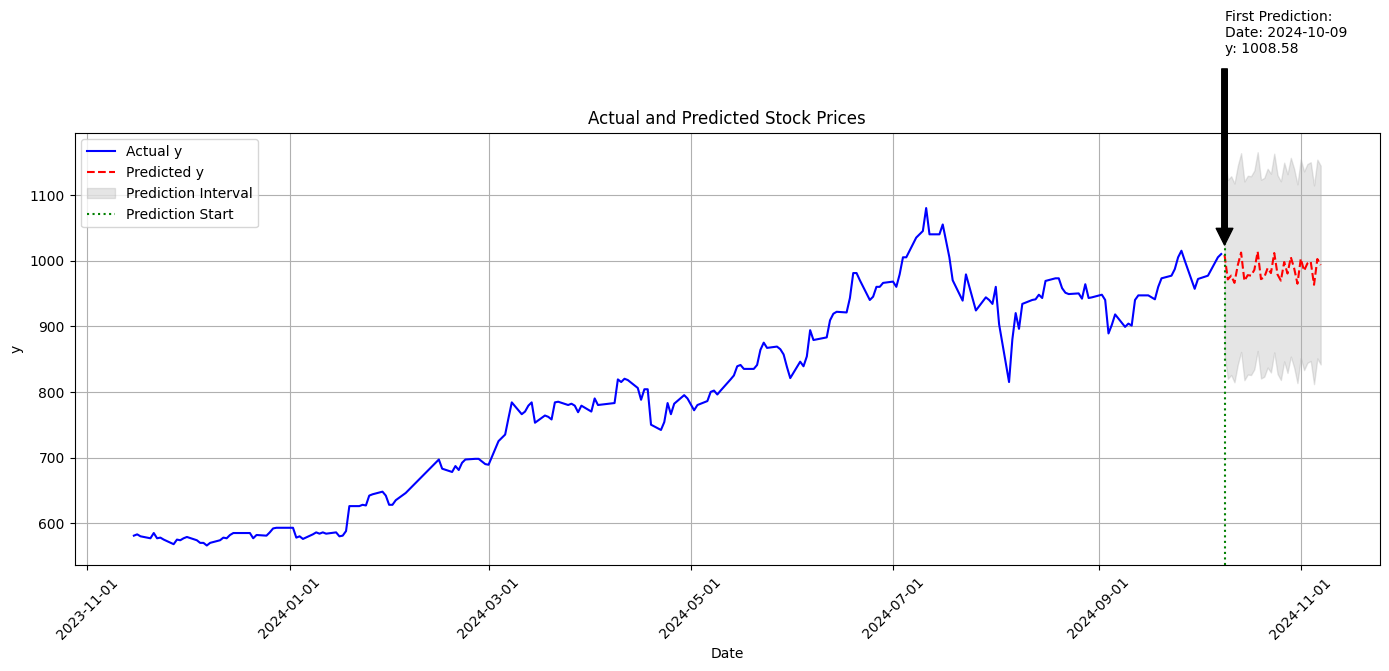

Predicted Values for the Next 30 Days:
---------------------------------------
Date: 2024-10-09 | Predicted y: 1008.58 | Upper Bound: 1159.97 | Lower Bound: 857.19
Date: 2024-10-10 | Predicted y: 971.27 | Upper Bound: 1122.66 | Lower Bound: 819.88
Date: 2024-10-11 | Predicted y: 977.08 | Upper Bound: 1128.47 | Lower Bound: 825.69
Date: 2024-10-12 | Predicted y: 966.03 | Upper Bound: 1117.42 | Lower Bound: 814.64
Date: 2024-10-13 | Predicted y: 993.00 | Upper Bound: 1144.39 | Lower Bound: 841.61
Date: 2024-10-14 | Predicted y: 1012.21 | Upper Bound: 1163.61 | Lower Bound: 860.82
Date: 2024-10-15 | Predicted y: 969.21 | Upper Bound: 1120.60 | Lower Bound: 817.82
Date: 2024-10-16 | Predicted y: 977.76 | Upper Bound: 1129.15 | Lower Bound: 826.37
Date: 2024-10-17 | Predicted y: 977.12 | Upper Bound: 1128.52 | Lower Bound: 825.73
Date: 2024-10-18 | Predicted y: 985.87 | Upper Bound: 1137.26 | Lower Bound: 834.48
Date: 2024-10-19 | Predicted y: 1013.70 | Upper Bound: 1165.10 | Lower Bound: 8

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# 1. Load and Preprocess Data
def load_and_preprocess(csv_file):
    # Load CSV with parsing 'Date' column
    # Handle thousand separators and decimal points
    df = pd.read_csv(csv_file, parse_dates=['Date'], thousands=',', decimal='.')

    # Sort by Date in case it's not sorted
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Convert all columns except 'Date' to float
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Optionally, handle missing values if any
    df.dropna(inplace=True)

    return df

# 2. Train Linear Regression Model
def train_model(df):
    # Define independent variables X and dependent variable y
    X = df[['x1', 'x2', 'x3', 'x4', 'x5']]
    y = df['y']

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X, y)

    return model

# 3. Make Future Predictions
def predict_future(model, df, days=30):
    predictions = []
    last_date = df['Date'].iloc[-1]
    last_features = df[['x1', 'x2', 'x3', 'x4', 'x5']].iloc[-1].tolist()

    for i in range(days):
        # Prepare input features
        X_new = np.array(last_features).reshape(1, -1)

        # Predict y
        y_pred = model.predict(X_new)[0]
        predictions.append(y_pred)

        # Update features: shift left and append current prediction as 'x5'
        last_features = last_features[1:] + [y_pred]

    # Generate future dates
    future_dates = [last_date + timedelta(days=i+1) for i in range(days)]

    return future_dates, predictions

# 4. Calculate Prediction Intervals
def calculate_intervals(y, predictions, std_multiplier=1):
    # Calculate standard deviation from historical y
    y_std = np.std(y)

    # Define upper and lower bounds
    upper_bounds = [pred + std_multiplier * y_std for pred in predictions]
    lower_bounds = [pred - std_multiplier * y_std for pred in predictions]

    return upper_bounds, lower_bounds

# 5. Visualize Results
def plot_results(df, future_dates, predictions, upper_bounds, lower_bounds):
    plt.figure(figsize=(14, 7))

    # Plot historical data
    plt.plot(df['Date'], df['y'], label='Actual y', color='blue')

    # Plot predictions
    plt.plot(future_dates, predictions, label='Predicted y', color='red', linestyle='--')

    # Plot prediction intervals
    plt.fill_between(future_dates, lower_bounds, upper_bounds, color='gray', alpha=0.2, label='Prediction Interval')

    # Highlight prediction start point
    plt.axvline(x=future_dates[0], color='green', linestyle=':', label='Prediction Start')

    # Annotate the first prediction
    plt.annotate(
        f'First Prediction:\nDate: {future_dates[0].date()}\ny: {predictions[0]:.2f}',
        xy=(future_dates[0], predictions[0]),
        xytext=(future_dates[0], predictions[0] + (upper_bounds[0] - lower_bounds[0])),
        arrowprops=dict(facecolor='black', shrink=0.05),
        horizontalalignment='left',
        verticalalignment='bottom'
    )

    # Formatting the date axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)

    plt.xlabel('Date')
    plt.ylabel('y')
    plt.title('Actual and Predicted Stock Prices')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 6. Display and Print Results
def display_results(future_dates, predictions, upper_bounds, lower_bounds):
    print("Predicted Values for the Next 30 Days:")
    print("---------------------------------------")
    for date, pred, upper, lower in zip(future_dates, predictions, upper_bounds, lower_bounds):
        print(f"Date: {date.date()} | Predicted y: {pred:.2f} | Upper Bound: {upper:.2f} | Lower Bound: {lower:.2f}")

# Main Function
def main():
    # Specify your CSV file path
    csv_file = '2330-training.csv'  # Replace with your CSV file path

    # Load and preprocess data
    df = load_and_preprocess(csv_file)

    # Train the model
    model = train_model(df)

    # Make future predictions
    future_dates, predictions = predict_future(model, df, days=30)

    # Calculate prediction intervals
    upper_bounds, lower_bounds = calculate_intervals(df['y'], predictions, std_multiplier=1)

    # Plot the results
    plot_results(df, future_dates, predictions, upper_bounds, lower_bounds)

    # Display predicted values and their ranges
    display_results(future_dates, predictions, upper_bounds, lower_bounds)

if __name__ == "__main__":
    main()
